In [1]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Misc
import datetime
import os
from platform import python_version
import random
import warnings

# EDA Tools
import ppscore as pps #<! See https://github.com/8080labs/ppscore -> pip install git+https://github.com/8080labs/ppscore.git

# Machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
# from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold, train_test_split

# Ensemble Engines
#from catboost import CatBoostClassifier, Pool
#from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
#from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from bokeh.plotting import figure, show

# Jupyter
from ipywidgets import interact, Dropdown, Layout

In [2]:
# Configuration
%matplotlib inline

warnings.filterwarnings("ignore")

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

sns.set_theme() #>! Apply SeaBorn theme

In [3]:
# Constants

DATA_FOLDER_NAME    = 'BlockChainAttacksDataSet'
DATA_FOLDER_PATTERN = 'DataSet0'
DATA_FILE_EXT       = 'csv'

PROJECT_DIR_NAME = 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`

# Feature extractors constants

TRAIN_BY_TSX    = 1
TRAIN_BY_FILES  = 2

In [4]:
# CyVers Packages
from DataSetsAuxFun import *

In [5]:
# Parameters
dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

# Features Analysis
numCrossValPps = 4

# Training
trainMode = TRAIN_BY_FILES
testSetRatio = 1 / 3
numKFolds = 3
gridSearchScore = 'f1' #<! Use strings from `sklearn.metrics.get_scorer_names()`
gridSearchScore = 'recall' #<! We need to have better PD

# Amount USD Outlier threshold
amountUsdOutlierThr = 1e9

randomState = 42

lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Currency Type', 'Amount [USD]', 'Receiver Type', 'Gas Price', 'Gas Limit', 'Gas Used' ]#lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Amount [USD]', 'Receiver Type']
lSlctedFeaturesCalc   = [enumObj.name for enumObj in FeatureName if ((enumObj is not FeatureName.TIME_MAX) and (enumObj is not FeatureName.TIME_MIN))]
lSlctdFeatures        = lSlctedFeaturesRaw + lSlctedFeaturesCalc
lCatFeatures          = ['Currency', 'Currency Type', 'Receiver Type']#lCatFeatures          = ['Currency', 'Receiver Type']
# lFeaturesRemove       = [FeatureName.TIME_MAX.name, FeatureName.TIME_MIN.name] #<! Auxiliary features to be removed before processing

timeColStr = 'Block Time'

In [6]:
# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '')
numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfData.columns} with {len(dfData.columns)} columns')

The number of file found: 301
The number of rows (Samples): 1791104, The number of columns: 19, number of unique sender id's: (301,)
The data list of columns is: Index(['Transaction ID', 'Transaction Time', 'Block Time', 'Sender ID',
       'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash',
       'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used',
       'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level'],
      dtype='object') with 19 columns


In [7]:
# Convert time data into Pandas format
dfData[timeColStr] = pd.to_datetime(dfData[timeColStr], infer_datetime_format = 'True') #<! Stable time format

In [8]:
# Sort data by transaction date
dfData.sort_values(timeColStr, inplace = True)
# dfData.reset_index(drop = True, inplace = True)

In [9]:
# Meet the data
dfData.head(20)

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
831702,0x2971c7bcbf18c57a2879b07a0f6dbbc14b7c928a0335...,NaN,2016-02-12 11:01:25+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,Wallet,0.500000,ETH,0x0000000000000000000000000000000000000000,NaN,2.737825,5.000000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN
831701,0xc18b50d6311d2de6f6bfd450a38291297eb0e1c96320...,NaN,2016-05-11 09:23:12+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,Token,50.000000,ETH,0x0000000000000000000000000000000000000000,NaN,499.065146,3.221000e-08,174091.0,74091,NaN,NaN,NaN,0,NaN
831700,0x29d0b83aeead81925d6df3a5c252bb759811fbc5bb5d...,NaN,2016-05-13 11:44:02+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28,Wallet,26.000000,ETH,0x0000000000000000000000000000000000000000,NaN,275.227201,3.221000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN
831699,0x292d05383a2d9150c5b24718ceef760608561469222f...,NaN,2016-05-19 07:50:40+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28,Wallet,50.000000,ETH,0x0000000000000000000000000000000000000000,NaN,735.916238,2.000000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN
831698,0x4020de95411dd43e8613588f07a8e9643093c8e9c9a2...,NaN,2016-05-20 12:29:30+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28,Wallet,100.000000,ETH,0x0000000000000000000000000000000000000000,NaN,1369.368343,2.000000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN
831697,0xde1fb69bc6f78d32413ef8cc800ee4379855636c8daa...,NaN,2016-07-20 13:30:33+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0xbf4ed7b27f1d666546e30d74d50d173d20bca754,Smart Contract,5000.000000,DAO,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,ERC20,NaN,2.000000e-08,158971.0,43971,NaN,NaN,NaN,0,NaN
1782883,0xf8e45e7a318827cd54a415005b30fc67dc4c62e0bb42...,NaN,2016-08-03 10:46:16+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,1.000000,ETH,0x0000000000000000000000000000000000000000,NaN,10.221748,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN
1782882,0x056b34ec266003515e00f5c4dba9e07be9acf52a2e39...,NaN,2016-08-03 11:03:28+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,1.000000,ETH,0x0000000000000000000000000000000000000000,NaN,10.221748,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN
1782881,0x25f0d4e11d6eb9929b9ddc85a6a2485b93337d65640e...,NaN,2016-08-03 11:37:25+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,5.000000,ETH,0x0000000000000000000000000000000000000000,NaN,51.108739,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN
1782880,0x6008875514e32a1fc5152aac6deed0482ff5527aab3d...,NaN,2016-08-03 11:48:55+00:00,0x022026b542a9aa18aae7d61c54a4c17e448fda6b,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,NaN,27.000000,ETH,0x0000000000000000000000000000000000000000,NaN,275.987191,5.000000e-08,131561.0,31561,NaN,NaN,NaN,0,NaN


# Information about the Data Before Pre Processing

1. See the labeled cases.
2. Count the Labels data.
3. Number of unique assets.
4. Pandas' `info()` and `describe()`.

After this phase, the data is _read only_.

In [10]:
# Look at attack cases
dfData.loc[dfData['Label'] == 1, :]

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
1782556,0x477df43e6e4b318c8ffed00899a4d7f019c074a89882...,NaN,2017-06-11 12:49:35+00:00,0x1fb15d830ec3cecc9ceb52caff30ad9cb7edb75a,0x0c9d1b3ca852c67bbeabeeb51e9482a845d56868,NaN,6.100000e+01,ETH,0x0000000000000000000000000000000000000000,NaN,2.080586e+04,2.100000e-08,200000.0,21000,NaN,NaN,NaN,1,NaN
1782836,0x5aa40ba7c64177844bf740d6b5e77f6b39f546ce3314...,NaN,2017-06-11 13:08:20+00:00,0x5503ff6d5f128f482c9a01d4a7911e87be66fbf4,0x0c9d1b3ca852c67bbeabeeb51e9482a845d56868,NaN,2.000000e+01,ETH,0x0000000000000000000000000000000000000000,NaN,6.821593e+03,2.100000e-08,250000.0,21000,NaN,NaN,NaN,1,NaN
1782827,0x3acef6e3abf653b478be9774df4cca24109e9068d41f...,NaN,2017-06-11 17:30:19+00:00,0x27b206e22560a0d3c3b9122b102e85f178f5baa0,0x0c9d1b3ca852c67bbeabeeb51e9482a845d56868,NaN,2.890000e+01,ETH,0x0000000000000000000000000000000000000000,NaN,9.857202e+03,2.500000e-08,150000.0,21000,NaN,NaN,NaN,1,NaN
1715779,0x0e0d16475d2ac6a4802437a35a21776e5c9b681a77fe...,NaN,2017-07-18 22:33:23+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0xb3764761e297d6f121e79c32a65829cd1ddb4d32,Wallet,2.679300e+04,ETH,0x0000000000000000000000000000000000000000,NaN,6.122288e+06,2.100000e-08,162754.0,60001,NaN,NaN,NaN,1,NaN
1715751,0x97f7662322d56e1c54bd1bab39bccf98bc736fcb9c7e...,NaN,2017-07-19 12:14:18+00:00,0x50126e8fcb9be29f83c6bbd913cc85b40eaf86fc,0xb3764761e297d6f121e79c32a65829cd1ddb4d32,Wallet,4.405500e+04,ETH,0x0000000000000000000000000000000000000000,NaN,8.792960e+06,2.100000e-08,88926.0,58433,NaN,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1718152,0x3dbed4a1ebb2289273370ce0ef10302882927abe9462...,NaN,2022-08-01 23:25:20+00:00,0xf57113d8f6ff35747737f026fe0b37d4d7f42777,0x56d8b635a7c88fd1104d23d632af40c1c3aac4e3,Wallet,3.209368e+01,ETH,0x0000000000000000000000000000000000000000,NaN,5.398193e+04,2.220000e-07,514396.0,378464,NaN,NaN,NaN,1,NaN
1718151,0x7f819d5030ae9dd7e83d9611261760645c67d03f6c09...,NaN,2022-08-01 23:35:13+00:00,0xf57113d8f6ff35747737f026fe0b37d4d7f42777,0x56d8b635a7c88fd1104d23d632af40c1c3aac4e3,Wallet,4.660000e-15,ETH,0x0000000000000000000000000000000000000000,NaN,7.838173e-12,1.484129e-08,3000000.0,55484,NaN,NaN,NaN,1,NaN
1743959,0x78d9a54c8ec259f41f8e5ee555308b58fbeaee01c3e2...,NaN,2022-08-23 06:00:13+00:00,0x8c4e4633cc060e8ce493a863fc66ba1b90f6e905,0xbb42f789b39af41b796f6c28d4c4aa5ace389d8a,NaN,2.003487e+02,WETH,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,erc20,3.248595e+05,5.680000e-09,236634.0,141372,NaN,NaN,NaN,1,NaN
1743957,0x78d9a54c8ec259f41f8e5ee555308b58fbeaee01c3e2...,NaN,2022-08-23 06:00:13+00:00,0x8c4e4633cc060e8ce493a863fc66ba1b90f6e905,0xbb42f789b39af41b796f6c28d4c4aa5ace389d8a,NaN,6.014179e+00,XMON,0x3aada3e213abf8529606924d8d1c55cbdc70bf74,erc20,2.110676e+05,5.680000e-09,236634.0,141372,NaN,NaN,NaN,1,NaN


In [11]:
# Balance of labels: Highly imbalanced data (As expected)
dfData['Label'].value_counts()

0    1787795
1       3309
Name: Label, dtype: int64

In [12]:
# How many unique `Sender ID` (Assets) we have.
# It should match the number of files, if not, it either means we have duplications or teh same asset was attacked twice.
len(dfData['Sender ID'].unique())

301

In [13]:
dfData['Label'].value_counts()

0    1787795
1       3309
Name: Label, dtype: int64

In [14]:
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1791104 entries, 831702 to 1744126
Data columns (total 19 columns):
 #   Column            Dtype              
---  ------            -----              
 0   Transaction ID    object             
 1   Transaction Time  float64            
 2   Block Time        datetime64[ns, UTC]
 3   Sender ID         object             
 4   Receiver ID       object             
 5   Receiver Type     object             
 6   Amount            float64            
 7   Currency          object             
 8   Currency Hash     object             
 9   Currency Type     object             
 10  Amount [USD]      float64            
 11  Gas Price         float64            
 12  Gas Limit         float64            
 13  Gas Used          int64              
 14  Gas Predicted     float64            
 15  Balance In        float64            
 16  Balance Out       float64            
 17  Label             int64              
 18  Risk Level       

In [15]:
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
count,0.0,1.791104e+06,1.661494e+06,1.791104e+06,1.791104e+06,1.791104e+06,0.0,0.0,0.0,1.791104e+06,0.0
mean,NaN,1.346655e+71,5.233049e+04,7.490149e-08,4.710515e+05,1.943147e+05,NaN,NaN,NaN,1.847464e-03,NaN
std,NaN,1.090343e+74,1.249224e+06,1.101029e-07,1.109681e+06,4.163819e+05,NaN,NaN,NaN,4.294242e-02,NaN
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,2.100000e+04,1.926100e+04,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,4.250000e-01,1.615500e+02,2.500000e-08,1.000000e+05,2.216800e+04,NaN,NaN,NaN,0.000000e+00,NaN
50%,NaN,1.100000e+01,1.211592e+03,5.121056e-08,2.000000e+05,9.603500e+04,NaN,NaN,NaN,0.000000e+00,NaN
75%,NaN,2.501552e+03,7.908199e+03,9.579987e-08,4.100000e+05,2.310350e+05,NaN,NaN,NaN,0.000000e+00,NaN
max,NaN,1.160000e+77,6.141830e+08,2.192162e-05,3.005662e+07,1.996937e+07,NaN,NaN,NaN,1.000000e+00,NaN


# Pre Processing

1. Remove invalid data.
2. Remove outliers.

In [16]:
# Detecting invalid `Amount USD`

dsInValidTrnsUsd = ((dfData['Amount [USD]'] == 0) | (dfData['Amount [USD]'].isna()) | (dfData['Amount [USD]'] == ''))

print(f'Number of invalid `Amount [USD]`: {dsInValidTrnsUsd.sum()}')

Number of invalid `Amount [USD]`: 152722


In [17]:
# Remove invalid data
dfData.drop(dfData.index[dsInValidTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [18]:
# Detecting Outliers in the `Amount [USD]`

dsOutlierTrnsUsd = ((dfData['Amount [USD]'] >= amountUsdOutlierThr) | (dfData['Amount [USD]'] <= 0))

print(f'Number of outliers `Amount [USD]`: {dsOutlierTrnsUsd.sum()}')

Number of outliers `Amount [USD]`: 0


In [19]:
# Remove outliers
dfData.drop(dfData.index[dsOutlierTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [20]:
# From now on this is the data to work with
numRows, numCols = dfData.shape

print(f'The number of rows (Samples): {numRows}, The number of columns: {numCols}')

The number of rows (Samples): 1638382, The number of columns: 19


# Meet the Data

Basic infomration about the data.

In [21]:
# Basic Data Information
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1638382 entries, 831702 to 1744016
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype              
---  ------            --------------    -----              
 0   Transaction ID    1638382 non-null  object             
 1   Transaction Time  0 non-null        float64            
 2   Block Time        1638382 non-null  datetime64[ns, UTC]
 3   Sender ID         1638382 non-null  object             
 4   Receiver ID       1638382 non-null  object             
 5   Receiver Type     1617137 non-null  object             
 6   Amount            1638382 non-null  float64            
 7   Currency          1638145 non-null  object             
 8   Currency Hash     1638179 non-null  object             
 9   Currency Type     920776 non-null   object             
 10  Amount [USD]      1638382 non-null  float64            
 11  Gas Price         1638382 non-null  float64            
 12  Gas Limit         16383

In [22]:
# Numeric Data Description
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
count,0.0,1.638382e+06,1.638382e+06,1.638382e+06,1.638382e+06,1.638382e+06,0.0,0.0,0.0,1.638382e+06,0.0
mean,NaN,2.380397e+21,5.306870e+04,7.556866e-08,3.635956e+05,1.851227e+05,NaN,NaN,NaN,1.878683e-03,NaN
std,NaN,2.154477e+24,1.257988e+06,1.116532e-07,6.309217e+05,3.695103e+05,NaN,NaN,NaN,4.330305e-02,NaN
min,NaN,0.000000e+00,2.330000e-47,0.000000e+00,2.100000e+04,1.926100e+04,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,3.486872e-01,1.817000e+02,2.500000e-08,1.000000e+05,2.108000e+04,NaN,NaN,NaN,0.000000e+00,NaN
50%,NaN,6.200000e+00,1.281172e+03,5.200000e-08,2.000000e+05,9.192900e+04,NaN,NaN,NaN,0.000000e+00,NaN
75%,NaN,1.916132e+03,8.139789e+03,9.700000e-08,4.084375e+05,2.264720e+05,NaN,NaN,NaN,0.000000e+00,NaN
max,NaN,1.950000e+27,6.141830e+08,2.192162e-05,3.005662e+07,1.996937e+07,NaN,NaN,NaN,1.000000e+00,NaN


In [23]:
# How many times each hacker attacked
dsAttacksAsset = dfData[dfData['Label'] == 1]['Receiver ID'].value_counts()

print(f'There are {dsAttacksAsset.shape[0]} Attackers')
print(dsAttacksAsset.head(len(dsAttacksAsset))) #<! Last ones should be 1

There are 131 Attackers
0xeda5066780de29d00dfb54581a707ef6f52d8113    415
0xa14d5da3c6bf2d9304fe6d4bc6942395b4de048b    297
0xeb31973e0febf3e3d7058234a5ebbae1ab4b8c23    292
0x83a2eb63b6cc296529468afa85dbde4a469d8b37    189
0xb1af124c860f819bf8de7d4c459e5b31fecdb95e    142
                                             ... 
0xa3f447feb0b2bddc50a44ccd6f412a5f98619264      1
0x0ae1554860e51844b61ae20823ef1268c3949f7c      1
0xeeee458c3a5eaafcfd68681d405fb55ef80595ba      1
0x3ddd8b6d092df917473680d6c41f80f708c45395      1
0xb70f65c1faa2f1160d006b585ebf564781e8dae6      1
Name: Receiver ID, Length: 131, dtype: int64


Text(0, 0.5, 'Number of Attackers')

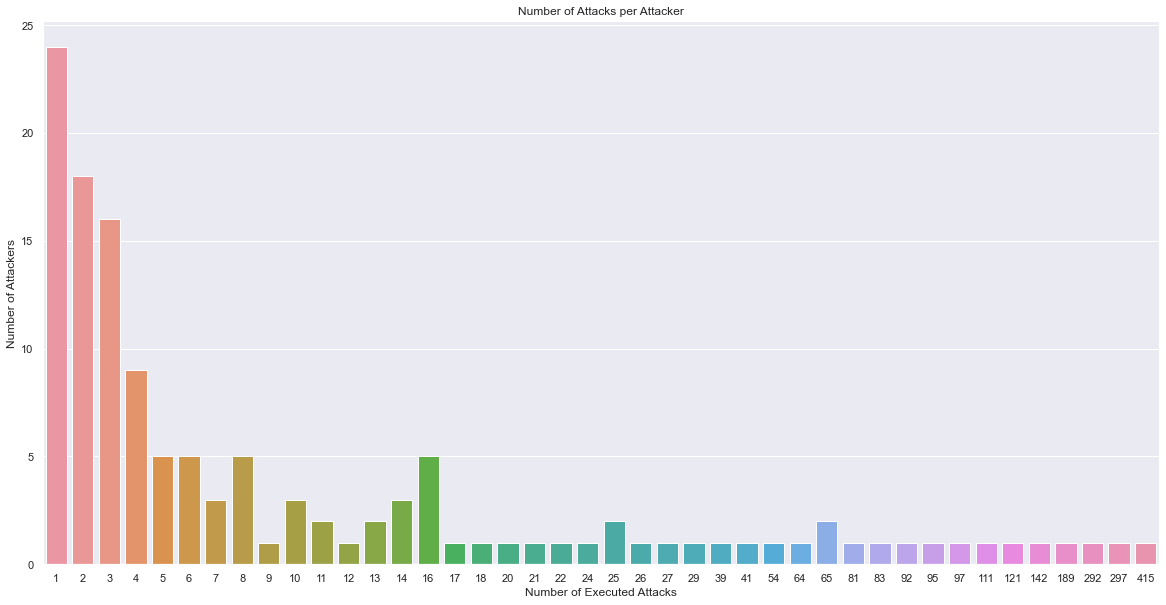

In [24]:
hF, hA = plt.subplots(figsize = (20, 10)) # 
sns.countplot(dsAttacksAsset, ax = hA)
hA.set_title('Number of Attacks per Attacker')
hA.set_xlabel('Number of Executed Attacks')
hA.set_ylabel('Number of Attackers')

In [25]:
# How many times each asset was attacked?
dsSenderCount = dfData[dfData['Label'] == 1]['Sender ID'].value_counts()

Text(0, 0.5, 'Number of Assets')

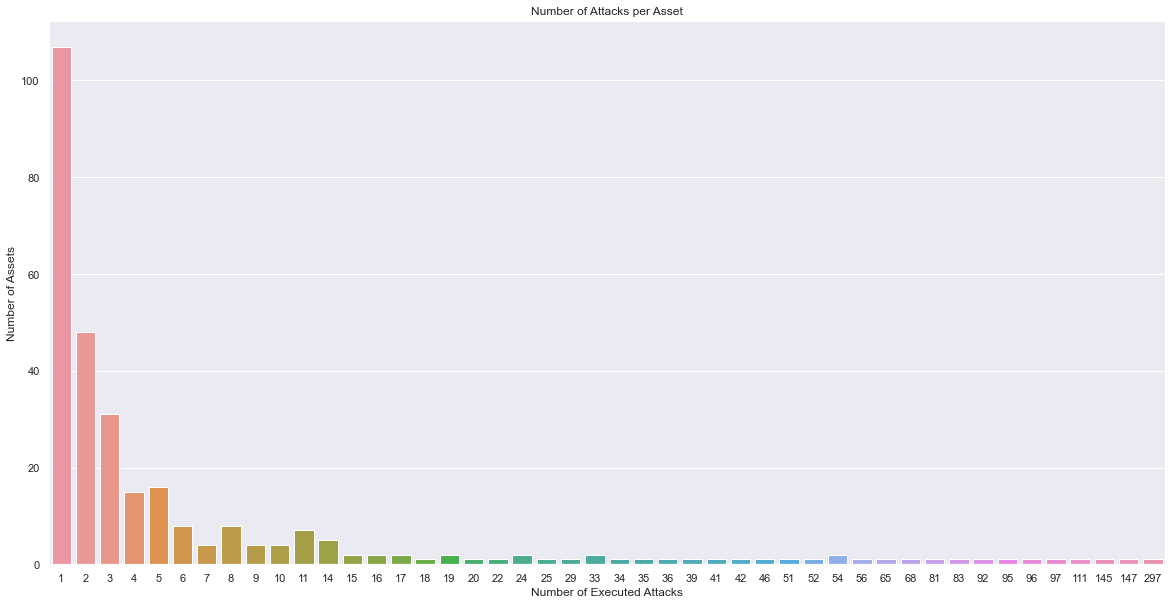

In [26]:
hF, hA = plt.subplots(figsize = (20, 10)) # TODO: Display an histogram (How many assets were attacked 1, 2, ...)
sns.countplot(dsSenderCount, ax = hA)
hA.set_title('Number of Attacks per Asset')
hA.set_xlabel('Number of Executed Attacks')
hA.set_ylabel('Number of Assets')

In [27]:
# How many different assets each attacker attacked? How many times per asset?
dsAttacksIdAttacker = dfData[dfData['Label'] == 1].groupby(['Receiver ID', 'Sender ID'])['Transaction ID'].count().reset_index(name = 'Number of Attacks')  
dsAttacksIdAttacker.head(40)

,Receiver ID,Sender ID,Number of Attacks
0,0x0217f93565ede01fa65450281631a67808d2eedc,0x37d387c2b7e5fb493091f01c164be5332811d11e,95
1,0x0333e323e61aa8afa38a1623604a165dcb9f4fec,0xe30dc9b3c29534e9b4e9a166c2f44411163ad59f,4
2,0x03d1d0e4061152c6a698309aaa4968aae58585a8,0x2f2ca827b3c2c57d554d08698e10c3d8016e9f81,1
3,0x079667f4f7a0b440ad35ebd780efd216751f0758,0x5dbcf33d8c2e976c6b560249878e6f1491bca25c,1
4,0x07ba7e8947f8fb4d33f3c7e25c2cb35b858f02eb,0x8484ef722627bf18ca5ae6bcf031c23e6e922b30,1
5,0x07e02088d68229300ae503395c6536f09179dc3e,0xc5ac25cfc2b8284e84ca47dad21cf1319f732c11,3
6,0x098b716b8aaf21512996dc57eb0615e2383e2f96,0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2,3
7,0x09923e35f19687a524bbca7d42b92b6748534f25,0xd47140f6ab73f6d6b6675fb1610bb5e9b5d96fe5,18
8,0x09b5027ef3a3b7332ee90321e558bad9c4447afa,0xc36442b4a4522e871399cd717abdd847ab11fe88,8
9,0x0ae1554860e51844b61ae20823ef1268c3949f7c,0x7ea2be2df7ba6e54b1a9c70676f668455e329d29,1


In [28]:
# Initialize the Pandas Extension (Don't change the Index from now on!)
numGrps = dfData.GrpBySender.numGrps

### SASA vs. SAMA Cases

Definitions:

 * SASA:
 * SAMA:

**Remark**: Move to:

SASASW - Single Asset, Single   Attacks, Single   Wallets  
SAMASW - Single Asset, Multiple Attacks, Single   Wallets (SAMA)  
SAMAMW - Single Asset, Multiple Attacks, Multiple Wallets (SAMA)  

In [29]:
# Analysis of Attack Type
# !!! The function `CalcAttackType()` uses the Pandas extension, hence it should be initialized before!
dsAttackType, dfAttackType = CalcAttackType(dfData)

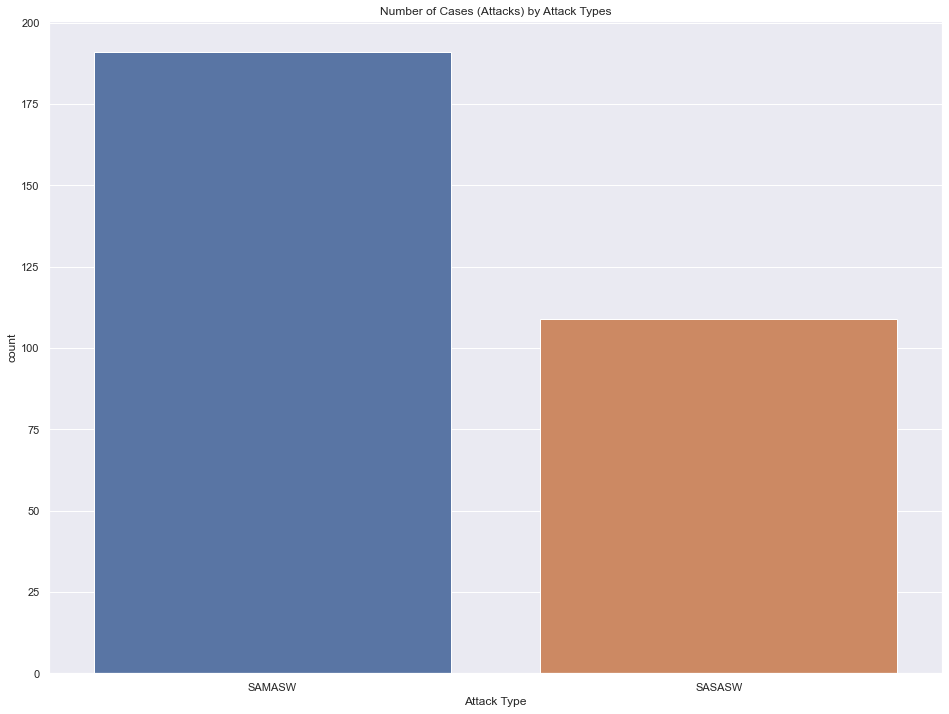

In [30]:
# Display an Histogram of the Attack Types
hF, hA = plt.subplots(figsize = (16, 12))
sns.countplot(x = dfAttackType['Attack Type'], ax = hA)
hA.set_title('Number of Cases (Attacks) by Attack Types')
plt.show()

## Feature Engineering

This section adds features and engineers them.  
Most features work on the `Sender ID` group.

#### Amount Based Features:

1. The STD of the user vs the average STD of all other users of the asset.
2. The Median of the user vs the average STD of all other users of the asset.
3. 

#### Date Based Features

1. The day of the week.
2. Weekend.
3. Hour of the day.
4. STD fo the time difference of the user vs. the avergae of all other users.
5. Median fo the time difference of the user vs. the avergae of all other users.

**Remark**: For wallets with a lot of activity we need to analyze the "activity hours" and profile it.


The features are:

 1. Day of the Week.

Remarks:

 *  Features x-y are time / frequency related.
 *  Features z-t are trasnaction realted.


In [31]:
# Pre Process

dfGbs = dfData.GrpBySender

### Features per Asset

In [32]:
# Features - Amount Based

sum_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MAX)
coint_c         = dfGbs.AggBySender(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggBySender(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE)

gas_pr_mean     = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_pr_std      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_pr_med      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)


dfData[FeatureName.AMOUNT_SUM_ASSET.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_ASSET.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_ASSET.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_ASSET.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_ASSET.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_ASSET.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_ASSET.name]          = max_s
dfData[FeatureName.TSX_COUNT_ASSET.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_ASSET.name]     = coint_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_ASSET.name] = receiver_type_c

dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_ASSET.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_ASSET.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_ASSET.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_ASSET.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_ASSET.name] = gas_pr_mean
dfData[FeatureName.GAS_USED_STD_ASSET.name] = gas_pr_std
dfData[FeatureName.GAS_USED_MEDIAN_ASSET.name] = gas_pr_med

#COIN_TYPE_COUNT_USR                 

In [33]:
# Features - Time Based

td_mean_s   = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_ASSET.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_ASSET.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_ASSET.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_ASSET.name]    = td_max_s

### Features per User

In [34]:
# Features - Amount Based (User)

sum_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
coin_c          = dfGbs.AggByReceiver(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggByReceiver(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE) #<! Royi: We need to check why is it so important?!?!

gas_pr_mean     = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)

gas_pr_std      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)

gas_pr_med      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)

gas_pr_quant    = dfGbs.dfSubGrpByRec[dfGbs.gasPriceColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_lim_quant   = dfGbs.dfSubGrpByRec[dfGbs.gasLimitColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_used_quant  = dfGbs.dfSubGrpByRec[dfGbs.gasUsedColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)


dfData[FeatureName.AMOUNT_SUM_USR.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_USR.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_USR.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_USR.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_USR.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_USR.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_USR.name]          = max_s
dfData[FeatureName.TSX_COUNT_USR.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_USR.name]     = coin_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_USR.name] = receiver_type_c    

dfData[FeatureName.GAS_PRICE_MEAN_USR.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_USR.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_USR.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_USR.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_USR.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_USR.name] = gas_pr_mean
dfData[FeatureName.GAS_USED_STD_USR.name] = gas_pr_std
dfData[FeatureName.GAS_USED_MEDIAN_USR.name] = gas_pr_med

dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name] = gas_pr_quant
dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name] = gas_lim_quant
dfData[FeatureName.GAS_USED_QUANTILE_USR.name] = gas_used_quant


In [35]:
# Features - Time Based (User)

td_mean_s   = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_USR.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_USR.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_USR.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_USR.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_USR.name]    = td_max_s

### Features based on Transaction Time

In [36]:
# Features - Time Based

dfData[FeatureName.TIME_HOUR.name]    = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.HOUR_DAY)
dfData[FeatureName.TIME_WEEKDAY.name] = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.DAY_WEEK)

### Features based on Ratios

In [37]:
# Ratio Based Features

dfData[FeatureName.AMOUNT_MEAN_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_MEAN_USR.name] / dfData[FeatureName.AMOUNT_MEAN_ASSET.name]
dfData[FeatureName.AMOUNT_STD_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_STD_USR.name] / dfData[FeatureName.AMOUNT_STD_ASSET.name]
dfData[FeatureName.TIME_DIFF_MEAN_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_MEAN_USR.name] / dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]
dfData[FeatureName.TIME_DIFF_STD_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_STD_USR.name] / dfData[FeatureName.TIME_DIFF_STD_ASSET.name]

### Features based on Frequency

In [38]:
# Frequency Based Features

dfData[FeatureName.TIME_MAX.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
dfData[FeatureName.TIME_MIN.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)

dfData[FeatureName.TIME_INTERVL_USR.name] = ((dfData[FeatureName.TIME_MAX.name] - dfData[FeatureName.TIME_MIN.name])).dt.total_seconds()

# Frequency of the User Transactions
dfData[FeatureName.TSX_FREQ_HZ_USR.name] = dfData[FeatureName.TSX_COUNT_USR.name] / dfData[FeatureName.TIME_INTERVL_USR.name]

### Gas ratio features(experimental)

In [39]:
#Ratios between the user to the mean of all users.
dfData[FeatureName.GAS_PRICE_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name]
dfData[FeatureName.GAS_LIMIT_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name]
dfData[FeatureName.GAS_USED_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_ASSET.name] 
#Gas Price', 'Gas Limit', 'Gas Used'
dfData[FeatureName.GAS_PRICE_LIMIT_RATIO.name] = dfData['Gas Price'] / dfData['Gas Limit']
dfData[FeatureName.GAS_PRICE_USED_RATIO.name] = dfData['Gas Price'] / dfData['Gas Used']
dfData[FeatureName.GAS_USED_LIMIT_RATIO.name] = dfData['Gas Used'] / dfData['Gas Limit'] 

dfData[FeatureName.GAS_PRICE_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_USR.name]
dfData[FeatureName.GAS_PRICE_USED_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_USR.name]
dfData[FeatureName.GAS_USED_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_USR.name] 


#Compare it to 75 quantile (TSX Gas Price / Quantile(75) of Gas Price).
dfData[FeatureName.GAS_PRICE_QUANTILE_RATIO.name] = dfData['Gas Price'] / dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name]
dfData[FeatureName.GAS_LIMIT_QUANTILE_RATIO.name] = dfData['Gas Limit'] / dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name]
dfData[FeatureName.GAS_USED_QUANTILE_RATIO.name] =  dfData['Gas Used'] / dfData[FeatureName.GAS_USED_QUANTILE_USR.name]

In [40]:
#Feature to indicate first transaction
dfData[FeatureName.MIN_INDICATOR.name] = 0 ; dfData.loc[dfData[timeColStr] == dfData[FeatureName.TIME_MIN.name], FeatureName.MIN_INDICATOR.name] = 1 
### TODO !!! this can be invorrect. it will need a review !!!!!! 

In [41]:
#56
#Create features based on the currency of the transactions:
# 1. The number of different types of currencies per user. <-- done previously = dfData[FeatureName.COIN_TYPE_COUNT_USR.name]
# 2. The average of the number of types of all user for an asset. <-- groupby asset , mean(number of different types of currencies per user)
# 3. The ratio between a specific user to the average of the asset. --> 1/2
    

dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]    = dfGbs.AvgByUserCoinType()
dfData[FeatureName.COIN_TYPE_USR_MEAN_ASSET_RATIO.name]  = dfData[FeatureName.COIN_TYPE_COUNT_USR.name] / dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]


## Features Pre Processing (For Training Phase)

In [42]:
dfData_ = dfData.copy(deep=True) ###<<-- I create a copy of data frame for experiment with categorical variables 

### K-fold training, using categorical variables (EXPERIMENT)

In [50]:
###### only pd.df approach is working, numpy(dtype=object) didn't work so it is not represented
#make sure below lists are defined
lNumericalFeatures = [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]
lTotalFeatures = lNumericalFeatures + lCatFeatures
feature_types_ = ['c' if x in lCatFeatures  else 'float' for x in lTotalFeatures]#feature_types_ = ['c' if x in lCatFeatures  else float for x in lTotalFeatures]

In [55]:
# Pre Processing Data categorical mine, here dfData_ <-- is used for experiment

dfData_.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_.fillna(0, inplace = True)
dfX_ = dfData_[lSlctdFeatures].copy()

for catColName in lCatFeatures:
    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[lNumericalFeatures] = hStdScaler.fit_transform(dfX_[lNumericalFeatures])


In [56]:
mX = dfX_[lTotalFeatures]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = dfData_['Label']


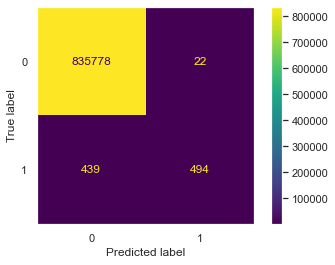

Accuracy         0.999449
F1               0.681850
Precision        0.957364
Recall           0.529475
ROC AUC Score    0.764724
dtype: float64


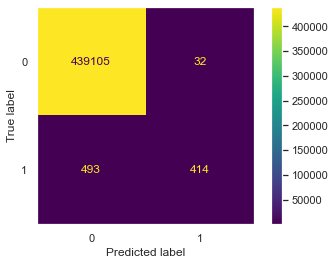

Accuracy         0.998807
F1               0.611973
Precision        0.928251
Recall           0.456450
ROC AUC Score    0.728188
dtype: float64


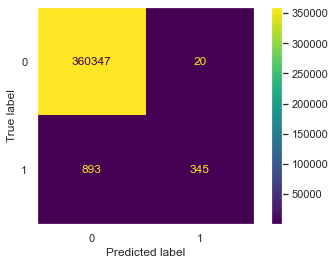

Accuracy         0.997475
F1               0.430443
Precision        0.945205
Recall           0.278675
ROC AUC Score    0.639310
dtype: float64


In [46]:
models = []
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))
    models.append([vTrainIdx, vTestIdx, xgbModel])

The vector `vT` matches `vYPred`
The vector `vT` matches `vYPred`


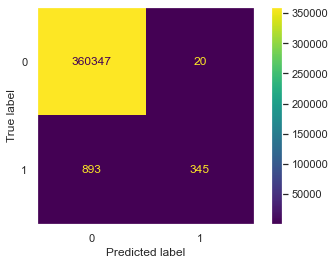

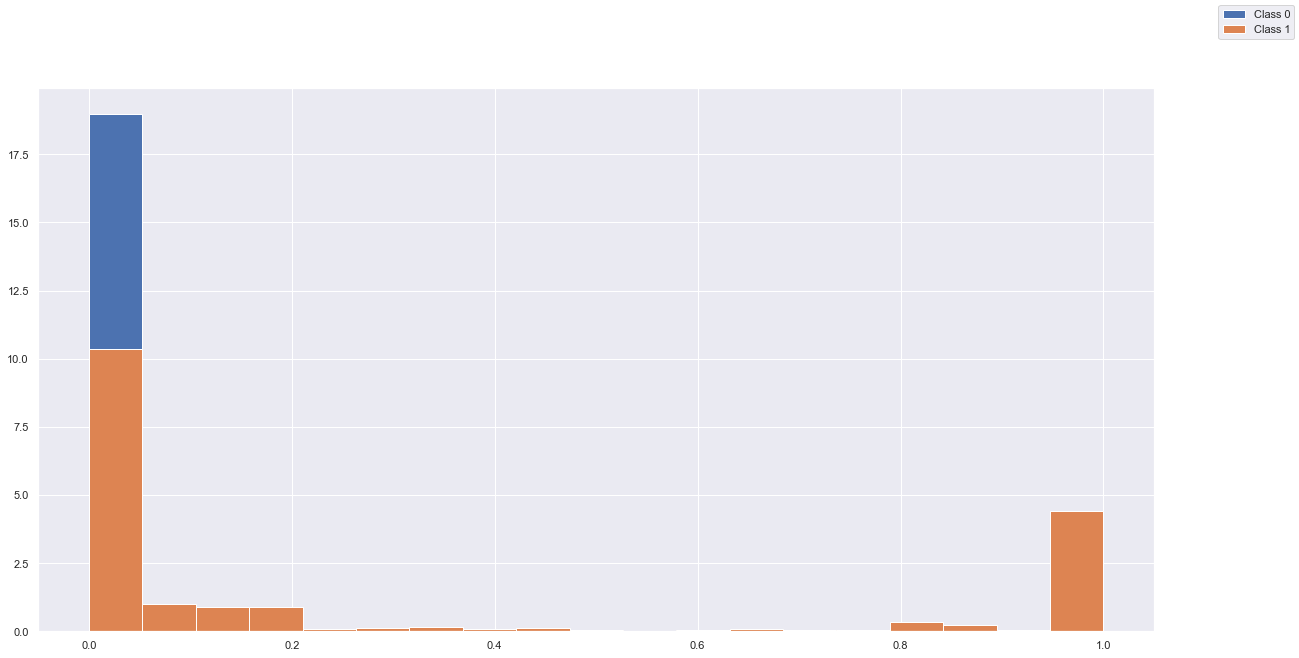

In [47]:
mYPredProb  = xgbModel.predict_proba(mXTest)
mYPredProb  = mYPredProb / np.sum(mYPredProb, axis = 1).reshape(-1, 1) #<! To have sum of 1 (We can do better with Soft Max or calibration)
vYPredProb  = mYPredProb[:, 1] #<! Probability for Label 1
vYPred      = xgbModel.predict(mXTest)

# %% Reproduce vYPred from mYPredProb

vT = np.argmax(mYPredProb, axis = 1)

if np.all(vT == vYPred):
    print('The vector `vT` matches `vYPred`')
else:
    print('The vector `vT` does not match `vYPred`')

vT = np.where(vYPredProb > 0.5, 1, 0)

if np.all(vT == vYPred):
    print('The vector `vT` matches `vYPred`')
else:
    print('The vector `vT` does not match `vYPred`')


# %% Analysis of Results vY = dsY.to_numpy()#dsY = dfData['Label']
vY = vYTest.to_numpy()
# %% Analysis of Results

DisplayConfusionMatrix(vY, vYPred, lClasses = xgbModel.classes_)

dsScoreSumm = GenClassifierSummaryResults(vY, vYPred)
dfScoreSummary  = pd.DataFrame(dsScoreSumm, columns = ['Score'])
dfScoreSummary

# %% Analysis of Prediction Probability

# Since the data is imbalanced, we need to process each group on its own.
vE = np.linspace(0, 1, 20) #<! Edges
vY0Idx = np.argwhere(vY == 0)
vY1Idx = np.argwhere(vY == 1)
vN0, *_ = np.histogram(vYPredProb[vY0Idx], bins = vE, density = True)
vN1, *_ = np.histogram(vYPredProb[vY1Idx], bins = vE, density = True)

# %%

edgeWidth = np.mean(np.diff(vE))

hF, hA = plt.subplots(figsize = (20, 10))
hA.bar(x = vE[:-1], height = vN0, width = edgeWidth, align = 'edge', label = 'Class 0')
hA.bar(x = vE[:-1], height = vN1, width = edgeWidth, align = 'edge', label = 'Class 1')
hF.legend()


# %% Optimize the Threshold
# We need Anton to first get us a real trained model


The vector `vT` matches `vYPred`
The vector `vT` matches `vYPred`


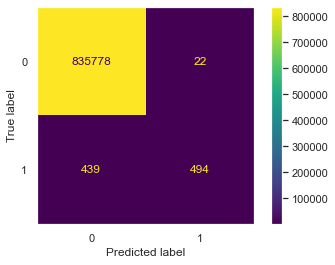

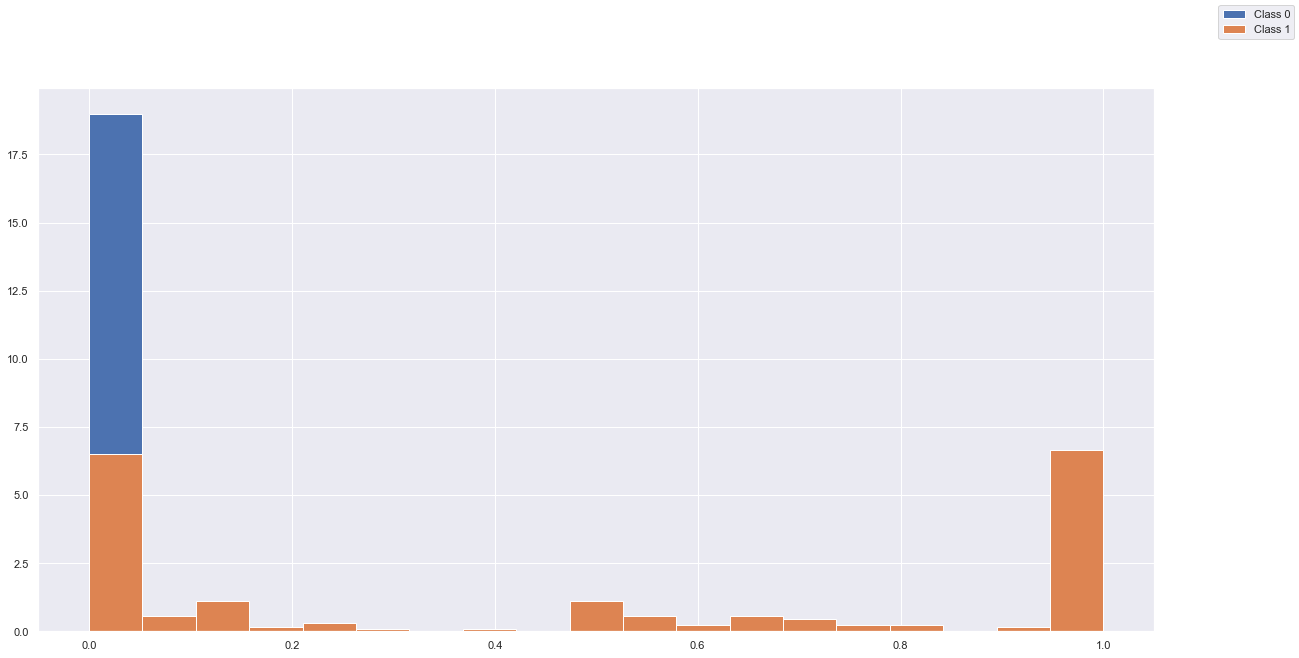

In [47]:
vTrainIdx = models[0][0]
vTestIdx  = models[0][1]
xgbModel  = models[0][2]
mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
mYPredProb  = xgbModel.predict_proba(mXTest)
mYPredProb  = mYPredProb / np.sum(mYPredProb, axis = 1).reshape(-1, 1) #<! To have sum of 1 (We can do better with Soft Max or calibration)
vYPredProb  = mYPredProb[:, 1] #<! Probability for Label 1
vYPred      = xgbModel.predict(mXTest)

# %% Reproduce vYPred from mYPredProb

vT = np.argmax(mYPredProb, axis = 1)

if np.all(vT == vYPred):
    print('The vector `vT` matches `vYPred`')
else:
    print('The vector `vT` does not match `vYPred`')

vT = np.where(vYPredProb > 0.5, 1, 0)

if np.all(vT == vYPred):
    print('The vector `vT` matches `vYPred`')
else:
    print('The vector `vT` does not match `vYPred`')


# %% Analysis of Results vY = dsY.to_numpy()#dsY = dfData['Label']
vY = vYTest.to_numpy()
# %% Analysis of Results

DisplayConfusionMatrix(vY, vYPred, lClasses = xgbModel.classes_)

dsScoreSumm = GenClassifierSummaryResults(vY, vYPred)
dfScoreSummary  = pd.DataFrame(dsScoreSumm, columns = ['Score'])
dfScoreSummary

# %% Analysis of Prediction Probability

# Since the data is imbalanced, we need to process each group on its own.
vE = np.linspace(0, 1, 20) #<! Edges
vY0Idx = np.argwhere(vY == 0)
vY1Idx = np.argwhere(vY == 1)
vN0, *_ = np.histogram(vYPredProb[vY0Idx], bins = vE, density = True)
vN1, *_ = np.histogram(vYPredProb[vY1Idx], bins = vE, density = True)

# %%

edgeWidth = np.mean(np.diff(vE))

hF, hA = plt.subplots(figsize = (20, 10))
hA.bar(x = vE[:-1], height = vN0, width = edgeWidth, align = 'edge', label = 'Class 0')
hA.bar(x = vE[:-1], height = vN1, width = edgeWidth, align = 'edge', label = 'Class 1')
hF.legend()


# %% Optimize the Threshold
# We need Anton to first get us a real trained model


In [ ]:
vTrainIdx = models[0][0]
vTestIdx  = models[0][1]
xgbModel  = models[0][2]
mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
mYPredProb  = xgbModel.predict_proba(mXTest)
mYPredProb  = mYPredProb / np.sum(mYPredProb, axis = 1).reshape(-1, 1) #<! To have sum of 1 (We can do better with Soft Max or calibration)
vYPredProb  = mYPredProb[:, 1] #<! Probability for Label 1
vYPred      = xgbModel.predict(mXTest)

# %% Reproduce vYPred from mYPredProb

vT = np.argmax(mYPredProb, axis = 1)

if np.all(vT == vYPred):
    print('The vector `vT` matches `vYPred`')
else:
    print('The vector `vT` does not match `vYPred`')

vT = np.where(vYPredProb > 0.5, 1, 0)

if np.all(vT == vYPred):
    print('The vector `vT` matches `vYPred`')
else:
    print('The vector `vT` does not match `vYPred`')


# %% Analysis of Results vY = dsY.to_numpy()#dsY = dfData['Label']
vY = vYTest.to_numpy()
# %% Analysis of Results

DisplayConfusionMatrix(vY, vYPred, lClasses = xgbModel.classes_)

dsScoreSumm = GenClassifierSummaryResults(vY, vYPred)
dfScoreSummary  = pd.DataFrame(dsScoreSumm, columns = ['Score'])
dfScoreSummary

# %% Analysis of Prediction Probability

# Since the data is imbalanced, we need to process each group on its own.
vE = np.linspace(0, 1, 20) #<! Edges
vY0Idx = np.argwhere(vY == 0)
vY1Idx = np.argwhere(vY == 1)
vN0, *_ = np.histogram(vYPredProb[vY0Idx], bins = vE, density = True)
vN1, *_ = np.histogram(vYPredProb[vY1Idx], bins = vE, density = True)

# %%

edgeWidth = np.mean(np.diff(vE))

hF, hA = plt.subplots(figsize = (20, 10))
hA.bar(x = vE[:-1], height = vN0, width = edgeWidth, align = 'edge', label = 'Class 0')
hA.bar(x = vE[:-1], height = vN1, width = edgeWidth, align = 'edge', label = 'Class 1')
hF.legend()


# %% Optimize the Threshold
# We need Anton to first get us a real trained model


In [58]:
def probs_vs_counts_visualization(vTrainIdx ,vTestIdx , mX, vY, xgbModel):
    
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    mYPredProb  = xgbModel.predict_proba(mXTest)
    mYPredProb  = mYPredProb / np.sum(mYPredProb, axis = 1).reshape(-1, 1) #<! To have sum of 1 (We can do better with Soft Max or calibration)
    vYPredProb  = mYPredProb[:, 1] #<! Probability for Label 1
    vYPred      = xgbModel.predict(mXTest)

    # %% Reproduce vYPred from mYPredProb

    vT = np.argmax(mYPredProb, axis = 1)

    if np.all(vT == vYPred):
        print('The vector `vT` matches `vYPred`')
    else:
        print('The vector `vT` does not match `vYPred`')

    vT = np.where(vYPredProb > 0.5, 1, 0)

    if np.all(vT == vYPred):
        print('The vector `vT` matches `vYPred`')
    else:
        print('The vector `vT` does not match `vYPred`')


    # %% Analysis of Results vY = dsY.to_numpy()#dsY = dfData['Label']
    vY = vYTest.to_numpy()
    # %% Analysis of Results

    DisplayConfusionMatrix(vY, vYPred, lClasses = xgbModel.classes_)

    dsScoreSumm = GenClassifierSummaryResults(vY, vYPred)
    dfScoreSummary  = pd.DataFrame(dsScoreSumm, columns = ['Score'])
    dfScoreSummary

    # %% Analysis of Prediction Probability

    # Since the data is imbalanced, we need to process each group on its own.
    vE = np.linspace(0, 1, 20) #<! Edges
    vY0Idx = np.argwhere(vY == 0)
    vY1Idx = np.argwhere(vY == 1)
    vN0, *_ = np.histogram(vYPredProb[vY0Idx], bins = vE, density = True)
    vN1, *_ = np.histogram(vYPredProb[vY1Idx], bins = vE, density = True)

    # %%

    edgeWidth = np.mean(np.diff(vE))

    hF, hA = plt.subplots(figsize = (20, 10))
    hA.bar(x = vE[:-1], height = vN0, width = edgeWidth, align = 'edge', label = 'Class 0')
    hA.bar(x = vE[:-1], height = vN1, width = edgeWidth, align = 'edge', label = 'Class 1')
    hF.legend()

The vector `vT` matches `vYPred`
The vector `vT` matches `vYPred`


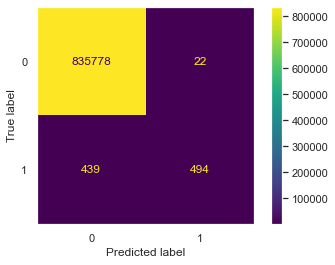

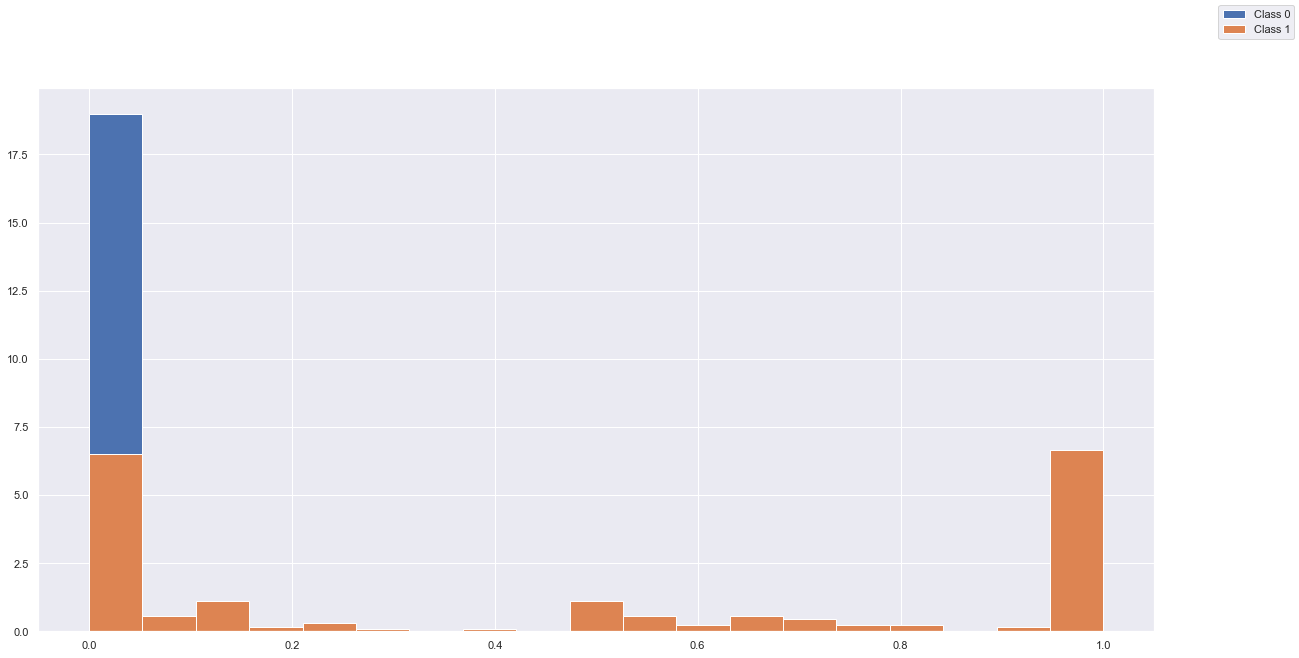

In [59]:
probs_vs_counts_visualization(models[0][0], models[0][1], mX, vY, models[0][2])